A collection of deep learning models in JAX.

*   Author: Tianlin Liu
*   GitHub Repository: https://github.com/liutianlin0121/jax-deep-learning-models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/liutianlin0121/jax-deep-learning-models/blob/main/ConvNet/resnet-cifar.ipynb)

## Description

In this notebook, we will be training a [ResNet-18](https://arxiv.org/abs/1512.03385) on the CIFAR-10 dataset.

## Imports

In [1]:
if 'google.colab' in str(get_ipython()):
  %pip install ml-collections -q
  %pip install "jax[cuda11_cudnn82]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html -q
  %pip install flax -q

In [2]:
from typing import Any
from matplotlib import pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import ml_collections
import optax
import copy
import torchvision
from torch.utils import data
from typing import Any, Callable, Sequence, Tuple
from functools import partial
import torchvision.transforms as transforms

## Prepare the CIFAR-10 dataset

In [3]:
# Helper functions for images.

def show_img(img, ax=None, title=None, mean=(1, 1, 1), std=(1, 1, 1)):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  # De-normalize the image.
  img = copy.copy(np.array(img.squeeze()))
  img[..., 0] = img[..., 0] * std[0] + mean[0]
  img[..., 1] = img[..., 1] * std[1] + mean[1]
  img[..., 2] = img[..., 2] * std[2] + mean[2]
  eps = 1e-6
  # Just to make sure de-noramlized pixels are in (0, 1).
  img = (1 - eps) * (img + eps)
  ax.imshow(img.squeeze(), cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  if title:
    ax.set_title(title)


def show_img_grid(imgs, titles, mean=(1, 1, 1), std=(1, 1, 1)):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(2 * n, 2 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title, mean, std)


def numpy_collate(batch):
  """Stack data into a numpy array.
  https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
  """
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple, list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)


class Cast(object):
  """Cast and normalize an image.
  https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
  """
  def __call__(self, pic):
    return np.array(pic, dtype=jnp.float32).transpose(1,2,0) # channel last


cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std= (0.2023, 0.1994, 0.2010)

# Augment the data with random cropping and flipping.
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
    Cast()
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
    Cast()
])


train_dataset = torchvision.datasets.CIFAR10(
    root='~/torch_datasets', train=True,
    download=True,
    transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(
    root='~/torch_datasets', train=False,
    download=True, transform=transform_test)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

test_images = jnp.array([test_data[0] for test_data in test_dataset])
test_labels = jnp.array([test_data[1] for test_data in test_dataset])

Files already downloaded and verified
Files already downloaded and verified


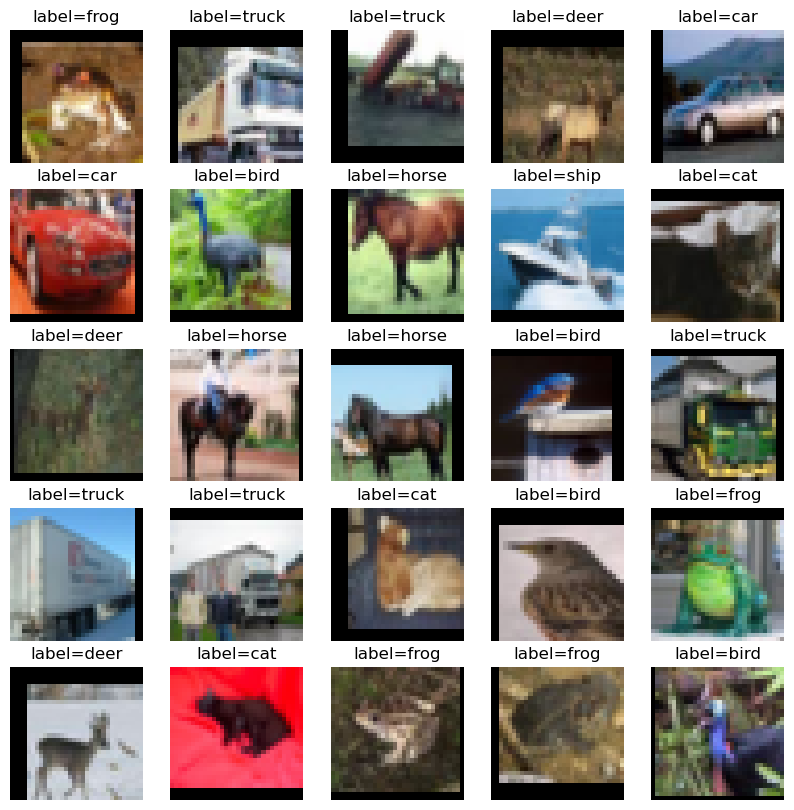

In [4]:
show_img_grid(
  [train_dataset[idx][0] for idx in range(25)],
  [f'label={classes[train_dataset[idx][1]]}' for idx in range(25)],
  mean=cifar_mean, std=cifar_std)


## Set up the model and the training loop




The implementation of the deep residual network is taken from the [jaxopt](https://jaxopt.github.io/stable/notebooks/deep_learning/resnet_flax.html) repository

In [5]:
class ResNetBlock(nn.Module):
  """ResNet block.
  https://jaxopt.github.io/stable/notebooks/deep_learning/resnet_flax.html
  """
  filters: int
  conv: Any
  norm: Any
  act: Callable
  strides: Tuple[int, int] = (1, 1)

  @nn.compact
  def __call__(self, x,):
    residual = x
    y = self.conv(self.filters, (3, 3), self.strides)(x)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters, (3, 3))(y)

    # Following Goyal et al. (2018), BNs' learnable scaling coefficient is
    # initialized to be 1, except for each residual block’s last BN
    # where it is initialized to be 0.
    y = self.norm(scale_init=nn.initializers.zeros)(y)

    if residual.shape != y.shape:
      residual = self.conv(self.filters, (1, 1),
                           self.strides, name='conv_proj')(residual)
      residual = self.norm(name='norm_proj')(residual)

    return self.act(residual + y)

class ResNet(nn.Module):
  """ResNetV1.
  https://jaxopt.github.io/stable/notebooks/deep_learning/resnet_flax.html
  """
  stage_sizes: Sequence[int]
  block_cls: Any
  num_classes: int
  num_filters: int = 64
  dtype: Any = jnp.float32
  act: Callable = nn.relu

  @nn.compact
  def __call__(self, x, train: bool = True):
    conv = partial(nn.Conv, use_bias=False, dtype=self.dtype)
    norm = partial(nn.BatchNorm,
                   use_running_average=not train,
                   momentum=0.99,
                   epsilon=0.001,
                   dtype=self.dtype)

    # x = conv(self.num_filters, (7, 7), (2, 2),
    #          name='conv_init')(x)
    # Note: The original ResNet paper was built on ImageNet images that
    # have a size of 224x224. In the first convolution, a ResNet has a kernel
    # size of 7x7 with a stride of 2. However, since CIFAR images are smaller,
    # we use a kernel size of 3x3 with a stride of 1.
    x = conv(self.num_filters, (3, 3), strides=1,
             name='conv_init')(x)

    x = norm(name='bn_init')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, (3, 3), strides=(2, 2), padding='SAME')
    for i, block_size in enumerate(self.stage_sizes):
      for j in range(block_size):
        strides = (2, 2) if i > 0 and j == 0 else (1, 1)
        x = self.block_cls(self.num_filters * 2 ** i,
                           strides=strides,
                           conv=conv,
                           norm=norm,
                           act=self.act)(x)
    x = jnp.mean(x, axis=(1, 2))
    x = nn.Dense(self.num_classes, dtype=self.dtype)(x)
    x = jnp.asarray(x, self.dtype)
    return x

ResNet18 = partial(ResNet, stage_sizes=[2, 2, 2, 2], block_cls=ResNetBlock)

In [6]:
# https://jaxopt.github.io/stable/_modules/jaxopt/_src/tree_util.html
from jax import tree_util
import operator


def tree_sum(tree_x):
  """Compute sum(tree_x)."""
  sums = tree_util.tree_map(jnp.sum, tree_x)
  return tree_util.tree_reduce(operator.add, sums)

def tree_l2_norm(tree_x, squared=False):
  """Compute the l2 norm ||tree_x||."""
  squared_tree = tree_util.tree_map(jnp.square, tree_x)
  sqnorm = tree_sum(squared_tree)
  if squared:
    return sqnorm
  else:
    return jnp.sqrt(sqnorm)


In [7]:
def create_learning_rate_fn(config, base_learning_rate, steps_per_epoch):
  """Creates learning rate schedule."""
  warmup_fn = optax.linear_schedule(
      init_value=0., end_value=base_learning_rate,
      transition_steps=config.warmup_epochs * steps_per_epoch)
  cosine_epochs = max(config.num_epochs - config.warmup_epochs, 1)
  cosine_fn = optax.cosine_decay_schedule(
      init_value=base_learning_rate,
      decay_steps=cosine_epochs * steps_per_epoch)
  schedule_fn = optax.join_schedules(
      schedules=[warmup_fn, cosine_fn],
      boundaries=[config.warmup_epochs * steps_per_epoch])
  return schedule_fn

In [8]:
@partial(jax.jit, static_argnums=[3,4])
def train_step(state, images, labels, l2reg, learning_rate_fn):
  """Train on a single batch"""
  def loss_fn(params):
    logits, updates = state.apply_fn(
      {'params': params, 'batch_stats': state.batch_stats},
      images,
      train=True,
      mutable=['batch_stats']
      )
    one_hot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(
      optax.softmax_cross_entropy(logits=logits, labels=one_hot))

    sqnorm = tree_l2_norm(params, squared=True)
    return loss + 0.5 * l2reg * sqnorm, (logits, updates)

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, (logits, updates)), grads = grad_fn(state.params)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  state = state.apply_gradients(grads=grads)
  state = state.replace(batch_stats=updates['batch_stats'])
  metrics = {'loss': loss,
             'accuracy': accuracy,
             'lr': learning_rate_fn(state.step)}

  return state, metrics


def train_epoch(state, train_loader, l2reg, learning_rate_fn):
  """Train for a single epoch."""

  batch_metrics = []
  for batch_images, batch_labels in train_loader:
    state, metrics = train_step(
      state, batch_images, batch_labels, l2reg, learning_rate_fn)
    batch_metrics.append(metrics)

  # compute mean of metrics across each batch in epoch.
  batch_metrics = jax.device_get(batch_metrics)
  epoch_metrics = {
      k: np.mean([metrics[k] for metrics in batch_metrics])
      for k in batch_metrics[0]}

  return state, epoch_metrics


class TrainState(train_state.TrainState):
  batch_stats: Any

def create_train_state(rng, config, learning_rate_fn):
  """Creates initial `TrainState`."""
  rng, params_key = jax.random.split(key=rng, num=2)

  convnet = ResNet18(num_classes=10) #()
  variables = convnet.init(
    params_key, jnp.ones([1, 32, 32, 3]), train=False)
  params = variables['params']
  batch_stats = variables['batch_stats']
  tx = optax.sgd(learning_rate_fn, config.momentum)

  state = TrainState.create(
    apply_fn=convnet.apply,
    params=params,
    batch_stats=batch_stats,
    tx=tx)
  return state


def evaluate_model(state, images, labels):
  logits = state.apply_fn(
    {'params': state.params, 'batch_stats': state.batch_stats},
    images,
    train=False,
    )

  one_hot = jax.nn.one_hot(labels, 10)
  loss = jnp.mean(
    optax.softmax_cross_entropy(logits=logits, labels=one_hot))

  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return loss, accuracy


def train_and_evaluate(
  config: ml_collections.ConfigDict) -> train_state.TrainState:
  """Execute model training and evaluation loop.

  Args:
    config: Hyperparameter configuration for training and evaluation.

  Returns:
    The train state (which includes the `.params`).
  """
  train_loader = data.DataLoader(
    train_dataset, batch_size=config.batch_size,
    shuffle=True, num_workers=4, pin_memory=True,
    collate_fn=numpy_collate, drop_last=True)

  rng = jax.random.PRNGKey(42)

  rng, params_key = jax.random.split(key=rng, num=2)
  learning_rate_fn = create_learning_rate_fn(
    config,
    base_learning_rate=config.learning_rate,
    steps_per_epoch=len(train_loader))
  state = create_train_state(params_key, config, learning_rate_fn)


  for epoch in range(1, config.num_epochs + 1):
    state, epoch_metrics = train_epoch(
      state, train_loader, config.l2reg, learning_rate_fn)

    train_loss = epoch_metrics['loss']
    train_accuracy = epoch_metrics['accuracy']
    learning_rate = epoch_metrics['lr']
    test_loss, test_accuracy = evaluate_model(state, test_images, test_labels)

    print(f'epoch: {epoch:02d}/{config.num_epochs:02d} | ' +\
          f'learning rate: {learning_rate:.4f} | ' +\
          f'train_loss: {train_loss:.4f} | ' +\
          f'train_accuracy: {train_accuracy * 100: .2f}  | ' +\
          f'test_loss: {test_loss: .4f}  | ' +\
          f'test_accuracy: {test_accuracy * 100:.2f}')

  return state


## Training

In [9]:
config = ml_collections.ConfigDict()

config.learning_rate = 0.1
config.momentum = 0.9
config.batch_size = 128
config.num_epochs = 100
config.warmup_epochs = 0
config.l2reg = 5e-4

state = train_and_evaluate(config)

epoch: 01/100 | learning rate: 0.1000 | train_loss: 3.1962 | train_accuracy:  42.32  | test_loss:  1.4603  | test_accuracy: 49.96
epoch: 02/100 | learning rate: 0.0999 | train_loss: 2.2863 | train_accuracy:  60.29  | test_loss:  1.3200  | test_accuracy: 53.07
epoch: 03/100 | learning rate: 0.0998 | train_loss: 1.8115 | train_accuracy:  67.24  | test_loss:  1.0286  | test_accuracy: 63.39
epoch: 04/100 | learning rate: 0.0997 | train_loss: 1.5119 | train_accuracy:  71.41  | test_loss:  1.1229  | test_accuracy: 61.40
epoch: 05/100 | learning rate: 0.0995 | train_loss: 1.3192 | train_accuracy:  74.21  | test_loss:  0.7946  | test_accuracy: 72.23
epoch: 06/100 | learning rate: 0.0993 | train_loss: 1.1956 | train_accuracy:  76.05  | test_loss:  1.0785  | test_accuracy: 62.72
epoch: 07/100 | learning rate: 0.0990 | train_loss: 1.1054 | train_accuracy:  77.78  | test_loss:  0.8727  | test_accuracy: 70.21
epoch: 08/100 | learning rate: 0.0986 | train_loss: 1.0561 | train_accuracy:  78.28  | tes

## Inference

In [10]:
# Find all mistakes in test set.
logits = ResNet18(num_classes=10).apply(
  {'params': state.params, 'batch_stats': state.batch_stats},
  test_images, train=False)
error_idxs, = jnp.where(test_labels != logits.argmax(axis=1))
correct_idxs, = jnp.where(test_labels == logits.argmax(axis=1))

print('error rate', len(error_idxs) / len(logits))

error rate 0.0735


### Show some correctly classified digits

Text(0.5, 0.95, 'Examples of correctly classified digits')

<Figure size 640x480 with 0 Axes>

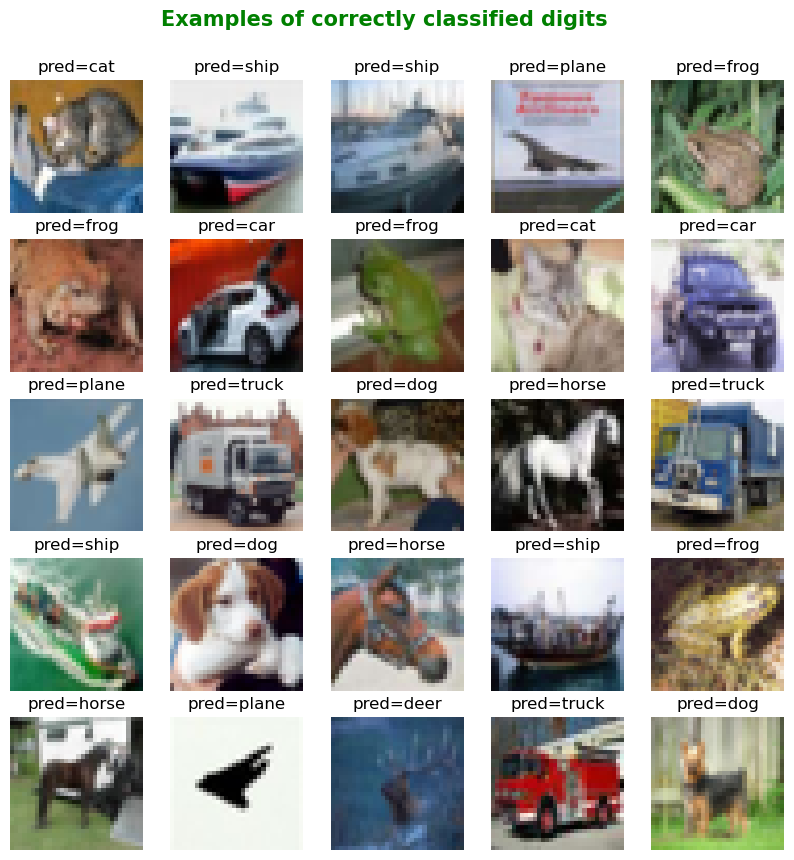

In [11]:
plt.figure()
show_img_grid(
    [test_images[idx] for idx in correct_idxs[:25]],
    [f'pred={classes[logits[idx].argmax()]}' for idx in correct_idxs[:25]],
    mean=cifar_mean, std=cifar_std)

plt.suptitle("Examples of correctly classified digits",
             y=0.95, fontsize=15, c='g', fontweight="bold")

### Show some wrongly classified digits

Text(0.5, 0.95, 'Examples of wrongly classified digits')

<Figure size 640x480 with 0 Axes>

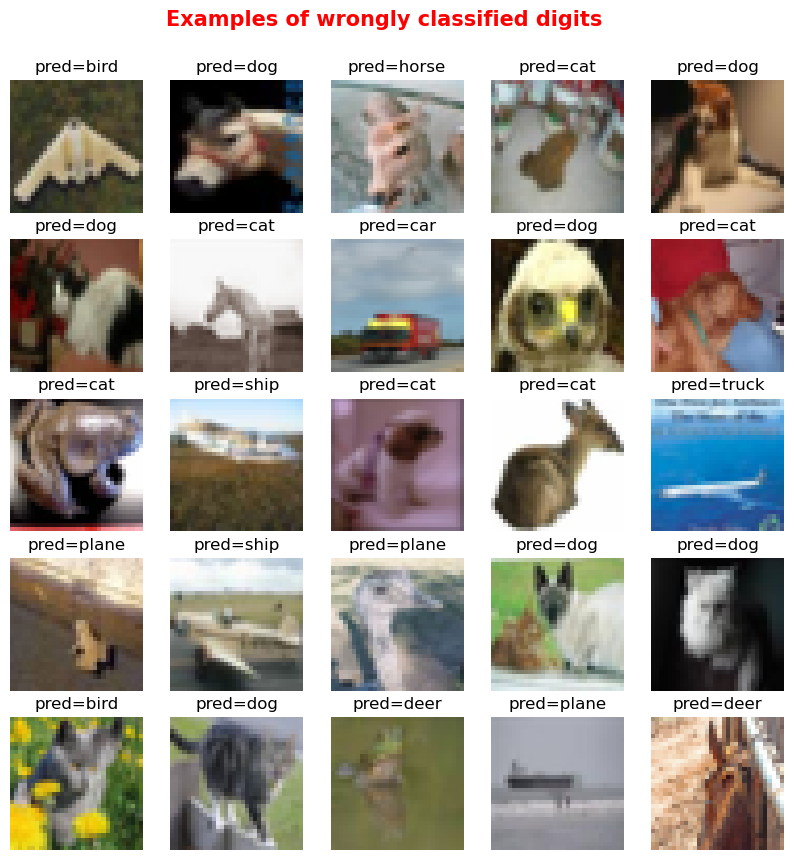

In [12]:
plt.figure()
show_img_grid(
    [test_images[idx] for idx in error_idxs[:25]],
    [f'pred={classes[logits[idx].argmax()]}' for idx in error_idxs[:25]],
    mean=cifar_mean, std=cifar_std)

plt.suptitle("Examples of wrongly classified digits",
             y=0.95, fontsize=15, c='r', fontweight="bold")